_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Name: FILL IN YOUR NAMES HERE

# Coding Lab 6



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$s and $0$s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## MLE

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [2]:
def entropy_mle(phat):
    '''Maximum likelihood or plug-in estimator of discrete entropy
    
    Parameter
    ---------
    
    phat: np.array, shape=(N, )
        Estimate of the distribution / histogram
    
    Return
    ------
    H: float
        Entropy estimate
    '''
    
    phat = phat[phat !=0]
    H = -np.sum(phat * np.log2(phat))
    
    return H


## Miller-Maddow corrected

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [3]:
def entropy_mm(phat, n):
    '''Miller-Maddow corrected estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(N, )
        Estimate of the distribution / histogram
        
    n:  int
        Number of bins
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''
    
    d = np.sum(phat>0)
    H_mle = entropy_mle(phat)
    H = H_mle + 0.5 * (d - 1) / n
    
    return H


## Jack-knife corrected

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [4]:
def entropy_jk(x, edges):
    '''Jack-knife corrected estimator of discrete entropy
    
    Parameters
    ----------
    x: np.array, shape=(n_samples,)
        Samples
        
    edges: np.array, shape=(n_bins, )
        Histogram bin edges
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    
    '''
    
    n_samples = len(x)
    phat = np.histogram(x, edges, density=False)[0]
    
    Hdot = []
    for i in range(np.min([n_samples, 1000])):
        phat[x[i]] -= 1
        Hdot.append(entropy_mle(phat/(n_samples-1)))
        phat[x[i]] += 1
        
    H_mle = entropy_mle(phat/n_samples)
    
    H = n_samples * H_mle - (n_samples - 1) * np.mean(Hdot)
    
    return H

## Coverage-adjusted

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [24]:
def entropy_cae(phat, n):
    '''coverage-adjusted estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(N, )
        Estimate of the distribution / histogram
        
    n:  int
        Number of bins
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''
    
    f = phat * n
    C = 1 - np.sum(f == 1) / n
    phatc = phat * C
    
    phatc = phatc[phatc != 0]
    
    upper = phatc * np.log2(phatc) # numerator
    lower = 1 - (1 - phatc) ** n # denominator
    
    H = -sum(upper /lower)
    
    return H

# JVWH

In [6]:
import est_entro as ee

def entropy_jvhw(x):
    '''JVHW estimator of discrete entropy
    
    Parameter
    ---------
    x: np.array, shape=(n_samples)
        Samples
        
    Return
    ------
    H: float
        Entropy estimate
    '''

    H = ee.est_entro_JVHW(x)[0]    
    
    return H

### Uniform distribution

In [7]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (1 pt)

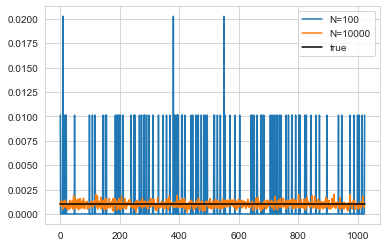

In [8]:
x = np.random.randint(0, N, 100)
edges = np.arange(-0.5, N+0.5, 1)
phat, bins = np.histogram(x, N, density=True)

# 100 samples
plt.plot(phat)

x = np.random.randint(0, N, 10000)
phat, bins = np.histogram(x, edges, density=True)

# 10000 samples
plt.plot(phat)

# true distribution: uniform
plt.plot(p, color='black') 

plt.legend(['N=100','N=10000','true'])



Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [9]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        
        # add sampling here...        
        x = np.random.randint(0, N,int(S))
        
        phat = np.histogram(x,edges, density=False)[0]
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        
        h_jvhw[i,j] = entropy_jvhw(x)
        


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

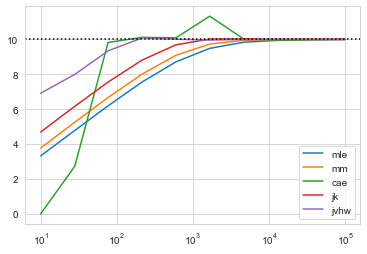

In [10]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))
plt.axhline(H, color='black', linestyle=':')

plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw'])


### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (3 pts)

In [97]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
p = p/np.sum(p)

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

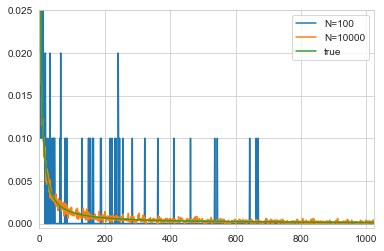

In [104]:
x = np.random.choice(np.arange(0,N), 100, p=p)

edges = np.arange(-0.5, N, 1)
phat, bins = np.histogram(x,edges, density=True)

plt.plot(phat, label='N=100')

x = np.random.choice(np.arange(0,N), 10000, p=p)
phat, bins = np.histogram(x,edges, density=True)

plt.plot(phat, label='N=10000')

plt.plot(p, label='true')

plt.xlim((0,N))
plt.ylim((-.0005, 0.025))

plt.legend()


Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [53]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        
        # add sampling here
        x = np.random.choice(np.arange(0,N), int(S), p=p)
#         x = np.random.zipf(2, int(S))
        phat = np.histogram(x,edges)[0]
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        
        h_jvhw[i,j] = entropy_jvwh(x)


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

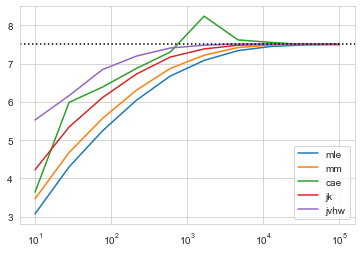

In [34]:
plt.figure()
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))

plt.axhline(H, color='black', linestyle=':')



plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw'])

